# Doing Benchmark Tests

In [1]:
from utils.libs import *

In [2]:
print(f"keras.__version__: {keras.__version__}")
print(f"sklearn.__version__: {sklearn.__version__}")
print(f"tf.__version__: {tf.__version__}")

keras.__version__: 2.4.3
sklearn.__version__: 0.23.1
tf.__version__: 2.2.0


In [3]:
opts = get_option_parser()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = opts.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

In [4]:
os.getcwd()

SEED = 1234
RANDOM_STATE = 42

N_FOLDS = 10

N_COMPONENTS = 2

target_names = ['Occupancy', 'Non-Occupancy']

np.random.seed(seed = SEED)

### Fetch Data: Training Set

In [5]:
dir_path = "C:\\Users\\Francesco\\Documents\\datasets\\occupancy_data"
file_name = "datatraining.txt"

file_path = os.path.join(dir_path, file_name)

print(file_path)

C:\Users\Francesco\Documents\datasets\occupancy_data\datatraining.txt


In [6]:
train_data = pd.read_csv(file_path)

In [7]:
train_data.describe(include="all")

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
unique,8143,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-02-07 11:06:59,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,NaN,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,NaN,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,NaN,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,NaN,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,NaN,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


### Fetch Data: Test Set

In [9]:
dir_path = "C:\\Users\\Francesco\\Documents\\datasets\\occupancy_data"
file_name = "datatest.txt"

file_path_test_set = os.path.join(dir_path, file_name)

print(file_path)

C:\Users\Francesco\Documents\datasets\occupancy_data\datatraining.txt


In [10]:
test_data = pd.read_csv(file_path_test_set)

In [11]:
test_data.describe(include="all")

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
unique,2665,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-02-03 11:31:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,NaN,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,NaN,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,NaN,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,NaN,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,NaN,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000


In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           2665 non-null   object 
 1   Temperature    2665 non-null   float64
 2   Humidity       2665 non-null   float64
 3   Light          2665 non-null   float64
 4   CO2            2665 non-null   float64
 5   HumidityRatio  2665 non-null   float64
 6   Occupancy      2665 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB


## Benchmark

### Preprocess data

In [13]:
targets_idx = 6
def filter_targets_idx(xx, targets_idx):
    if type(targets_idx) is list:
        return xx not in targets_idx 
    return xx != targets_idx
features_idx = list(filter(lambda xx: filter_targets_idx(xx, targets_idx), range(len(train_data.columns))))[1:]

In [14]:
pprint(dict(zip("features_idx, targets_idx".split(","), [features_idx, targets_idx])))

{' targets_idx': 6, 'features_idx': [1, 2, 3, 4, 5]}


In [15]:
X_train = train_data.iloc[:, features_idx].values
y_train = train_data.iloc[:, targets_idx].values

In [16]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_samples = X_train.shape[0]

print("n_classes: %d, \t n_samples: %d, \t n_features: %d"
      % (n_classes, n_samples, n_features))

n_classes: 2, 	 n_samples: 8143, 	 n_features: 5


In [17]:
estimator = KNeighborsClassifier() # RandomForestClassifier(random_state=0)
scaler = StandardScaler()

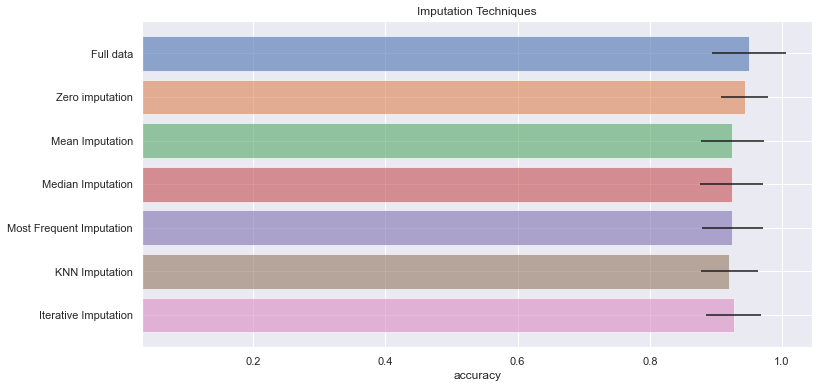

In [18]:
x_labels, results_performance = benchmark_imputing_missing_values(
    estimator = estimator,
    scaler = scaler,
    scoring = 'accuracy',
    X_train = X_train, y_train = y_train,
    random_state = 42, cv = 5, missing_rate = .75)

In [19]:
benchmark_df = pd.DataFrame(data = results_performance, index = x_labels, columns = "mean,std".split(","))

In [20]:
benchmark_df.sort_values(by = "mean", ascending = False)

,mean,std
Full data,0.950273,0.055461
Zero imputation,0.943392,0.036056
Iterative Imputation,0.926932,0.041845
Most Frequent Imputation,0.924967,0.046207
Mean Imputation,0.924599,0.047493
Median Imputation,0.924107,0.047613
KNN Imputation,0.920178,0.043028


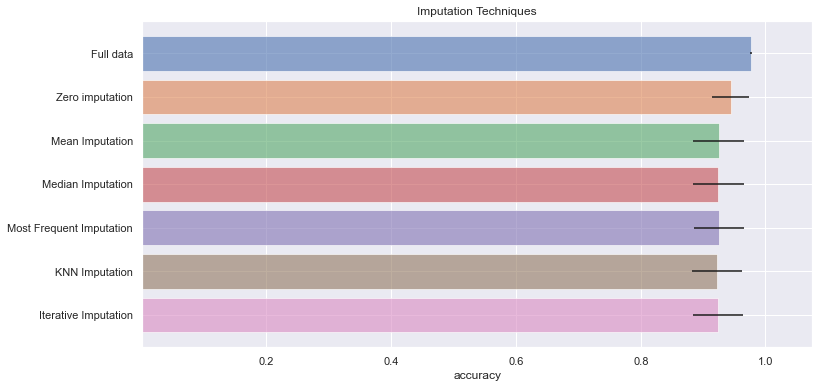

In [21]:
cv = StratifiedKFold(2)
x_labels, results_performance = benchmark_imputing_missing_values(
    estimator = estimator,
    scaler = scaler,
    scoring = 'accuracy',
    X_train = X_train, y_train = y_train,
    random_state = 42, cv = cv, missing_rate = .75)

In [22]:
benchmark_df = pd.DataFrame(data = results_performance, index = x_labels, columns = "mean,std".split(","))

In [23]:
benchmark_df.sort_values(by = "mean", ascending = False)

,mean,std
Full data,0.976790,0.001108
Zero imputation,0.944496,0.029466
Most Frequent Imputation,0.925954,0.040394
Mean Imputation,0.924971,0.040885
Median Imputation,0.924603,0.040762
Iterative Imputation,0.924112,0.040516
KNN Imputation,0.922269,0.039902


### Perform benchmark

### Show Benchmark plots

### References

- (Logistic Regression with Keras) https://aigeekprogrammer.com/binary-classification-using-logistic-regression-and-keras/
- (panda-ml) https://pandas-ml.readthedocs.io/en/latest/index.html

### Tutorials
- (Imputing missing values before building an estimator) https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
- (K-means) https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
- (Column Transformer with Mixed Types) https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
- (Feature transformations with ensembles of trees) https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py
- (Test with permutations the significance of a classification score) https://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py
- (Imputing missing values before building an estimator) https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
- (Permutation Importance vs Random Forest Feature Importance (MDI)) https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

### Theory
- (Glossary) https://scikit-learn.org/stable/glossary.html#glossary
- (6.3. Preprocessing data) https://scikit-learn.org/stable/modules/preprocessing.html